# Introduction to QRenderers

For convenience, let's begin by enabling [automatic reloading of modules](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) when they change.

In [1]:
%load_ext autoreload
%autoreload 2

### Import Qiskit Metal

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross

from qiskit_metal.renderers.renderer_gds.gds_renderer import QGDSRenderer 

In [3]:
Headings.h1('The default_options in a QComponent are different than the default_options in QRenderers.')


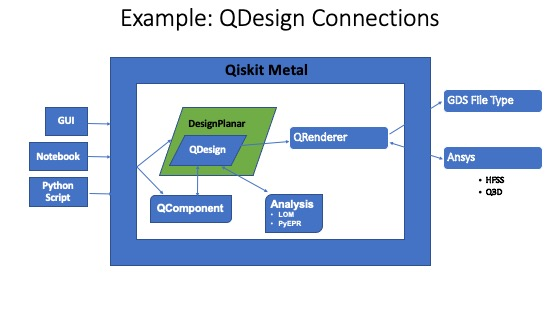

In [4]:
TransmonPocket.default_options


{'chip': 'main',
 'pos_x': '0um',
 'pos_y': '0um',
 'pad_gap': '30um',
 'inductor_width': '20um',
 'pad_width': '455um',
 'pad_height': '90um',
 'pocket_width': '650um',
 'pocket_height': '650um',
 'orientation': '0',
 '_default_connection_pads': {'pad_gap': '15um',
  'pad_width': '125um',
  'pad_height': '30um',
  'pad_cpw_shift': '5um',
  'pad_cpw_extent': '25um',
  'cpw_width': 'cpw_width',
  'cpw_gap': 'cpw_gap',
  'cpw_extend': '100um',
  'pocket_extent': '5um',
  'pocket_rise': '65um',
  'loc_W': '+1',
  'loc_H': '+1'}}

In [5]:
QGDSRenderer.default_options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': '1',
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

### A renderer needs to inherent from QRenderer
For Example, QGDSRender inherents from QRenderer.

When any QRenderer is registered within QDesign, the QRenderer instance has options, which hold the latest set of values for default_options.  The GUI can also update these options. 

An example of updating options is further below in this notebook.


### A user can customize things two ways

1.  Directly update the options that originated from default_options, for either QComponent or QRenderer.

2.  Pass options to a QComponent which will be placed in a QGeometry table, then used by QRenderer.

### How to get options from QRenderer to be placed within the QGeometry table?
We set this up so that older QComponents can be agnostic of newer QRenderers. 

The "rate limiting factor" is to have QComponent denote in it's metadata, which QGeometry tables it will write to.  For this example, we will discuss the "junction" table.  More details will be in the notebook at "tutorials/4 Plugin Developer".  
If the QComponent identifies the table which it is aware of, and if QGDSRenderer wants to add a column to the table with a default value, then QComponent will pass the option from QGDSRenderer to QGeometry table without doing anything with it.

An example of this below is `gds_cell_name='FakeJunction_01'`.  This is passed through to QGeometry, when a QComponent is instantiated.  The QGDSRenderer has a default, which is not editable during run-time, but can be customized when a QComponent is instantiated.  

In [6]:
Headings.h1('How does a QRenderer get registered within QDesign?')

### By default, QRenderers are registered within QDesign during init QDesign
The list of QRenderers which will be registered are in qiskit_metal.config.py;   
the dictionary `renderers_to_load` has the name of the QRenderer (key), class name (value), and path (value).

Presently, GDS and Ansys QRenderers are registered during init.  


In [7]:
design = designs.DesignPlanar()

In [8]:
# Use GDS QRenderer for remaining examples.  Can do similar things with Ansys QRenderer.

#an_ansys = design._renderers['ansys']
#an_ansys = design._renderers.ansys

#a_gds = design._renderers['gds']
a_gds = design._renderers.gds


In [9]:
gui = MetalGUI(design)
design.overwrite_enabled = True

In [10]:
Headings.h1('Populate QDesign to demonstrate exporting to GDS format.')

In [11]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

# Allow running the same cell here multiple times to overwrite changes
design.overwrite_enabled = True

## Custom options for all the transmons
options = dict(
    # Some options we want to modify from the deafults
    # (see below for defaults)
    pad_width = '425 um',
    pad_gap = '80 um',
    pocket_height = '650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict( 
        a = dict(loc_W=+1,loc_H=+1), 
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        d = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

# Note:  
The cell name denoted by, "gds_cell_name" will be the selected cell   
from design.renderers.gds.options['path_filename']   
when design.renderers.gds.export_to_gds() is executed.

In [12]:
## Create 4 TransmonPockets

q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.55mm', pos_y='+0.0mm', gds_cell_name='FakeJunction_02', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.9mm', orientation = '90', gds_cell_name='FakeJunction_02', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.55mm', pos_y='+0.0mm', gds_cell_name='FakeJunction_01',**options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.9mm', orientation = '90', gds_cell_name='my_other_junction', **options))

In [13]:
## Rebuild the design
gui.rebuild()
gui.autoscale()

#Connect using techniques explained earlier notebooks.

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
RouteMeander.get_template_options(design)

options = Dict(
    meander=Dict(
        lead_start='0.1mm',
        lead_end='0.1mm',
        asymmetry='0 um')
)


def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='50um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        lead=Dict(
            start_straight='0.13mm',
            end_straight='0.13mm'
        ),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)


asym = 90
cpw1 = connect('cpw1', 'Q1', 'd', 'Q2', 'c', '5.7 mm', f'+{asym}um', fillet='25um')
cpw2 = connect('cpw2', 'Q3', 'c', 'Q2', 'a', '5.4 mm', f'-{asym}um', flip=True, fillet='100um')
cpw3 = connect('cpw3', 'Q3', 'a', 'Q4', 'b', '5.3 mm', f'+{asym}um', fillet='75um')
cpw4 = connect('cpw4', 'Q1', 'b', 'Q4', 'd', '5.5 mm', f'-{asym}um', flip=True)

gui.rebuild()
gui.autoscale()


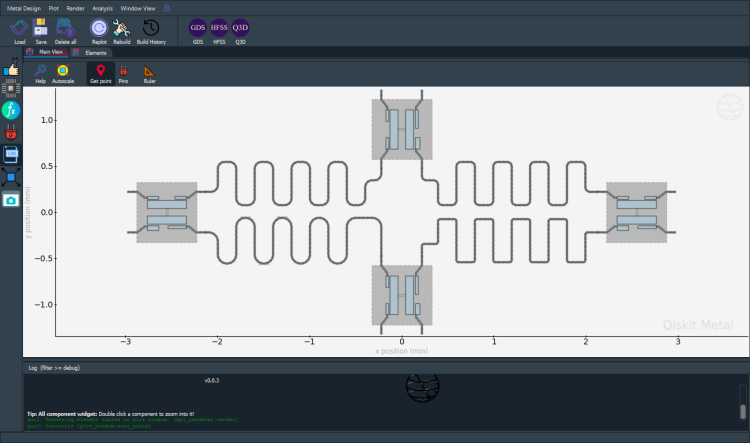

In [14]:
gui.screenshot()

In [15]:
Headings.h1('Exporting a GDS file.')

In [16]:
#QDesign enables GDS renderer during init.
a_gds = design.renderers.gds
# An alternate way to envoke the gds commands without using a_gds:
# design.renderers.gds.export_to_gds()

#Show the options for GDS
a_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

###  To make the junction table work correctly, GDS Renderer needs the correct path to the gds file which has cells
Each cell is a junction to be placed in a Transmon.  A sample gds file is provided in directory `qiskit_metal/tutorials/resources`.
There are three cells with names "Fake_Junction_01", "Fake_Junction_01", and "my_other_junction".
The default name used by GDS Render is "my_other_junction".  If you want to customize and select a junction, through the options, 
you can pass it when a qcomponent is being added to QDesign. 

This allows for an already prepared e-beam pattern for a given junction structure to be automatically imported and placed at the correct
location.

In [17]:
a_gds.options['path_filename'] = '../resources/Fake_Junctions.GDS'

Do you want GDS Renderer to fix any short-segments in your QDesign when using fillet?'



In [18]:
#If you have a fillet_value and there are LineSegments that are shorter than 2*fillet_value, 
#When true, the short segments will not be fillet'd. 
a_gds.options['short_segments_to_not_fillet'] = 'True'
scale_fillet = 2.0
a_gds.options['check_short_segments_by_scaling_fillet'] = scale_fillet

In [19]:
# Export GDS file for all components in design.
#def export_to_gds(self, file_name: str, highlight_qcomponents: list = []) -> int:


# Please change the path where you want to write a GDS file.
#Examples below.  
#a_gds.export_to_gds("../../../gds-files/GDS QRenderer Notebook.gds")

a_gds.export_to_gds('GDS QRenderer Notebook.gds')



1

In [20]:
# Export a GDS file which contains only few components.

# You will probably want to put the exported file in a specific directory.  
# Please give the full path for output. 
a_gds.export_to_gds("four_qcomponents.gds",
                           highlight_qcomponents=['cpw1', 'cpw4', 'Q1', 'Q3'])



1

## How to "execute" exporting an QRenderer from GUI vs notebook?
Within the GUI, there are icons: GDS, HFSS and Q3D.

Example for GDS:
Select the components that you want to export from QGeometry Tables. Select the path/file_name and the same thing should happen as the cells above.  

In [21]:
Headings.h1('QUESTION:  Where is the geometry of a QComponent placed?')

### Answer:  QGeometry tables!

## What is QGeometry? 

###  All QRenderers use the QGeometry tables to export from QDesign.  Each table is a Pandas DataFrame.


We can get all the QGeometry of a QComponent. There are several kinds, such as `path`, `poly` and, `junction`. 

In [22]:
#Many ways to view the QGeometry tables.  
#If you want to view, uncomment below lines and and run it.

#design.qgeometry.tables
#design.qgeometry.tables['path']
#design.qgeometry.tables['poly']

In [23]:
design.qgeometry.tables['junction']

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name
0,1,rect_jj,"LINESTRING (2.55000 -0.04000, 2.55000 0.04000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_02
1,2,rect_jj,"LINESTRING (0.04000 -0.90000, -0.04000 -0.90000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_02
2,3,rect_jj,"LINESTRING (-2.55000 -0.04000, -2.55000 0.04000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_01
3,4,rect_jj,"LINESTRING (0.04000 0.90000, -0.04000 0.90000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,my_other_junction


### Let us look at all the polygons used to create qubit `q1`

Poly table hold the polygons identified from QComponents.

In [24]:
q1.qgeometry_table('poly')

,component,name,geometry,layer,subtract,helper,chip,fillet
0,1,pad_top,"POLYGON ((2.33750 0.04000, 2.76250 0.04000, 2....",1,False,False,main,NaN
1,1,pad_bot,"POLYGON ((2.33750 -0.13000, 2.76250 -0.13000, ...",1,False,False,main,NaN
2,1,rect_pk,"POLYGON ((2.22500 -0.32500, 2.87500 -0.32500, ...",1,True,False,main,NaN
3,1,a_connector_pad,"POLYGON ((2.63750 0.14500, 2.76250 0.14500, 2....",1,False,False,main,NaN
4,1,b_connector_pad,"POLYGON ((2.46250 0.14500, 2.33750 0.14500, 2....",1,False,False,main,NaN
5,1,c_connector_pad,"POLYGON ((2.56250 -0.14500, 2.76250 -0.14500, ...",1,False,False,main,NaN
6,1,d_connector_pad,"POLYGON ((2.46250 -0.14500, 2.33750 -0.14500, ...",1,False,False,main,NaN


Paths are lines. These can have a width.

In [25]:
q1.qgeometry_table('path')

,component,name,geometry,layer,subtract,helper,chip,width,fillet,hfss_wire_bonds,q3d_wire_bonds
0,1,a_wire,"LINESTRING (2.76250 0.15500, 2.78750 0.15500, ...",1,False,False,main,0.010,NaN,False,False
1,1,a_wire_sub,"LINESTRING (2.76250 0.15500, 2.78750 0.15500, ...",1,True,False,main,0.022,NaN,False,False
2,1,b_wire,"LINESTRING (2.33750 0.15500, 2.31250 0.15500, ...",1,False,False,main,0.010,NaN,False,False
3,1,b_wire_sub,"LINESTRING (2.33750 0.15500, 2.31250 0.15500, ...",1,True,False,main,0.022,NaN,False,False
4,1,c_wire,"LINESTRING (2.76250 -0.15500, 2.78750 -0.15500...",1,False,False,main,0.010,NaN,False,False
5,1,c_wire_sub,"LINESTRING (2.76250 -0.15500, 2.78750 -0.15500...",1,True,False,main,0.022,NaN,False,False
6,1,d_wire,"LINESTRING (2.33750 -0.15500, 2.31250 -0.15500...",1,False,False,main,0.010,NaN,False,False
7,1,d_wire_sub,"LINESTRING (2.33750 -0.15500, 2.31250 -0.15500...",1,True,False,main,0.022,NaN,False,False


### The junction table is handled differently by each QRenderer.

###  What does GDS do with "junction" table?
This is better explained in folder 5 All QRenderers/5.2 GDS/GDS QRenderer  notebook.

In [26]:
q1.qgeometry_table('junction')

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name
0,1,rect_jj,"LINESTRING (2.55000 -0.04000, 2.55000 0.04000)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,FakeJunction_02


### Geometric boundary of a QComponent?
Return the boundry box of the geometry, for example: `q1.qgeometry_bounds()`.  
The function returns a tuple containing (minx, miny, maxx, maxy) bound values
for the bounds of the component as a whole.

In [27]:
for name, qcomponent in design.components.items():
    print(f"{name:10s} : {qcomponent.qgeometry_bounds()}")

Q1         : [ 2.125 -0.325  2.975  0.325]
Q2         : [-0.325 -1.325  0.325 -0.475]
Q3         : [-2.975 -0.325 -2.125  0.325]
Q4         : [-0.325  0.475  0.325  1.325]
cpw1       : [ 0.22       -0.54399198  2.125      -0.07600802]
cpw2       : [-2.125      -0.55810289 -0.22       -0.06189711]
cpw3       : [-2.125       0.07552405 -0.22        0.54447595]
cpw4       : [0.22       0.07576603 2.125      0.54423397]


###  Qiskit Metal Version

In [28]:
metal.about();


Qiskit Metal        0.0.3

Basic
____________________________________
 Python              3.7.8 | packaged by conda-forge | (default, Nov 27 2020, 18:48:03) [MSC v.1916 64 bit (AMD64)]
 Platform            Windows AMD64
 Installation path   c:\workspace\qiskit-metal\qiskit_metal

Packages
____________________________________
 Numpy               1.19.5
 Qutip               4.5.3

Rendering
____________________________________
 Matplotlib          3.3.4

GUI
____________________________________
 PySide2 version     5.13.2
 Qt version          5.9.7
 SIP version         4.19.8

IBM Quantum Team


In [29]:
# gui.main_window.close()